<a href="https://colab.research.google.com/github/ray-hsiehjy/Early-biomarker-Parkinson/blob/master/PD_biomarkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PD-biomarker dataset from [Kaggle](https://www.kaggle.com/ruslankl/early-biomarkers-of-parkinsons-disease)
- Original paper by [Hlavnicka et al, 2017](https://www.nature.com/articles/s41598-017-00047-5) on Nature

## Question
- Are speech and motor tests sufficient biomarkers for early PD diagnostic? 

## Dataset overview

### Sample subjects
- 30 Parkinson's Disease subjects, 50 REM sleep behavior disorder (RBD) subjects and 50 healthy control subjects are included in the dataset
- RBD subjects have high risk for PD

### Feature information
- Basic info: 
    - 3 features (all three groups)
    - Participant_code, Age, Gender

- Clinical info: 
    - 3 features (PD and RBD groups)
    - Family_history, Age_of_onset, Years_of_condition

- Medication: 
    - 6 features (all three groups)

- Hoehn_Yahr score (PD group)

- UPDRS_III_total score: 
    - 28 features (PD and RBD groups)

- speech task, reading passage: 
    - 12 features (all three grups)

- speech task, monologue: 
    - 12 features (all three grups)


## Strategy
- Given low sample number and high feature dimensions, SVC is used. 

- In contrast, for large sample number and relatively low feature dimensions, try KNN first

- Medication features are very sparse and are excluded.

- Clinical features other than years_of_symptoms are excluded

- UPDRS scale data for healty control subjects are NaN
    - assuming they are all 0, aka clinically defined as normal

- Years of symtoms for healthy subjects are NaN and are assumed 0

- SVC and neural-network performace are compared

# Load Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K

%matplotlib inline

## Load CSV and Clean headers

In [2]:
# load data from CSV
df = pd.read_csv("/content/PD_dataset.csv")
df.head()

,Participant code,Age (years),Gender,Positive history of Parkinson disease in family,Age of disease onset (years),Duration of disease from first symptoms (years),Antidepressant therapy,Antiparkinsonian medication,Antipsychotic medication,Benzodiazepine medication,Levodopa equivalent (mg/day),Clonazepam (mg/day),Overview of motor examination: Hoehn & Yahr scale (-),Overview of motor examination: UPDRS III total (-),18. Speech,19. Facial Expression,20. Tremor at Rest - head,20. Tremor at Rest - RUE,20. Tremor at Rest - LUE,20. Tremor at Rest - RLE,20. Tremor at Rest - LLE,21. Action or Postural Tremor - RUE,21. Action or Postural Tremor - LUE,22. Rigidity - neck,22. Rigidity - RUE,22. Rigidity - LUE,22. Rigidity - RLE,22. Rigidity - LLE,23.Finger Taps - RUE,23.Finger Taps - LUE,24. Hand Movements - RUE,24. Hand Movements - LUE,25. Rapid Alternating Movements - RUE,25. Rapid Alternating Movements - LUE,26. Leg Agility - RLE,26. Leg Agility - LLE,27. Arising from Chair,28. Posture,29. Gait,30. Postural Stability,31. Body Bradykinesia and Hypokinesia,Entropy of speech timing (-),Rate of speech timing (-/min),Acceleration of speech timing (-/min2),Duration of pause intervals (ms),Duration of voiced intervals (ms),Gaping in-between voiced intervals (-/min),Duration of unvoiced stops (ms),Decay of unvoiced fricatives (‰/min),Relative loudness of respiration (dB),Pause intervals per respiration (-),Rate of speech respiration (-/min),Latency of respiratory exchange (ms),Entropy of speech timing (-) .1,Rate of speech timing (-/min) .1,Acceleration of speech timing (-/min2) .1,Duration of pause intervals (ms) .1,Duration of voiced intervals (ms) .1,Gaping in-between voiced Intervals (-/min),Duration of unvoiced stops (ms) .1,Decay of unvoiced fricatives (‰/min) .1,Relative loudness of respiration (dB) .1,Pause intervals per respiration (-) .1,Rate of speech respiration (-/min) .1,Latency of respiratory exchange (ms) .1
0,PD01,58,F,No,56,2,No,No,No,No,0,0.0,1.5,8,0,1,0,0,2,0,2,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1.564,354,6.05,146,264,58.65,31.38,-2.101,-22.47,4.5,21.14,167,1.564,333,-2.82,158,318,49.01,22.37,0.588,-19.77,6.0,13.81,127
1,PD02,68,F,No,67,1,No,No,No,No,0,0.0,2.5,22,1,1,0,0,0,0,0,1,1,1,0,1,1,2,1,2,0,1,1,2,1,2,0,1,0,1,1,1.564,340,27.52,173,253,48.26,22.38,-1.745,-24.59,7.0,15.28,163,1.569,285,8.20,295,264,40.56,26.88,-0.825,-23.26,4.0,21.77,313
2,PD03,68,M,No,67,1,No,No,No,No,0,0.0,2,19,0,2,0,0,0,0,0,0,0,2,0,0,2,2,1,1,0,1,0,0,1,2,0,3,0,0,2,1.550,211,11.97,377,322,47.54,38.12,2.657,-16.89,3.0,20.76,372,1.550,247,4.71,280,317,48.97,22.37,-0.955,-13.29,4.0,22.52,201
3,PD04,75,M,No,73,2,No,No,No,No,0,0.0,2,24,0,2,0,1,0,1,0,1,1,1,1,1,1,1,1,1,2,2,1,2,1,0,0,1,1,0,1,1.519,140,-2.49,360,663,13.72,44.88,-0.934,-25.54,1.0,18.71,119,1.539,112,-9.09,397,800,18.69,49.37,0.791,-25.08,2.0,14.37,151
4,PD05,61,M,Yes,60,0.7,No,No,No,No,0,0.0,2.5,54,1,3,3,2,1,1,0,1,2,3,3,3,1,1,3,4,2,4,2,3,1,3,1,2,1,1,2,1.543,269,6.72,211,328,42.90,47.12,-0.973,-22.61,5.0,16.26,78,1.560,230,11.77,206,480,33.54,26.87,0.075,-22.32,5.0,14.61,151


In [0]:
# clean columns names

new_col_names = [
    # basic info
    "Participant_code", "Age", "Gender_male",
    # clinical info
    "Family_history", "Age_of_onset", "Years_of_symptoms",
    # medicine info
    "Antidepressant", "Antiparkinsonian", "Antipsychotic", 
    "Benzodiazepine", "Levodopa_equivalent", "Clonazepam",
    # Hoehn_Yahr
    "Hoehn_Yahr_scale",
    # UPDRS scores
    "UPDRS_III_total",
    "Speech", "Facial_Expression", "Tremor_Rest_head",
    "Tremor_Rest_RUE", "Tremor_Rest_LUE", "Tremor_Rest_RLE",
    "Tremor_Rest_LLE", "Tremor_Action_RUE", "Tremor_Action_LUE",
    "Rigidity_neck", "Rigidity_RUE", "Rigidity_LUE",
    "Rigidity_RLE", "Rigidity_LLE", "Finger_Taps_RUE",
    "Finger_Taps_LUE", "Hand_Movements_RUE", "Hand_Movements_LUE",
    "Rapid_Alt_Movements_RUE", "Rapid_Alt_Movements_LUE", "Leg_Agility_RLE",
    "Leg_Agility_LLE", "Arising_from_Chair", "Posture",
    "Gait", "Postural_Stability", "Body_Bradykinesia_Hypokinesia",
    # speech task, reading paragraph
    "R_Entropy_speech_timing", "R_Rate_speech_timing", "R_Acc_speech_timing",
    "R_Duration_pause_intervals", "R_Duration_voiced_intervals", "R_Gaping_in-between_voiced_intervals",
    "R_Duration_unvoiced_stops", "R_Decay_unvoiced_fricatives", "R_Relative_loudness_respiration",
    "R_Pause_intervals_per_respiration", "R_Rate_speech_respiration", "R_Latency_respiratory_exchange",
    # speech task, monologue
    "M_Entropy_speech_timing", "M_Rate_speech_timing", "M_Acc_speech_timing",
    "M_Duration_pause_intervals", "M_Duration_voiced_intervals", "M_Gaping_in-between_voiced_intervals",
    "M_Duration_unvoiced_stops", "M_Decay_unvoiced_fricatives", "M_Relative_loudness_respiration",
    "M_Pause_intervals_per_respiration", "M_Rate_speech_respiration", "M_Latency_respiratory_exchange",
]

# assign new column names
df.columns = new_col_names

# set subject ID as inex
df.set_index("Participant_code", inplace=True)

# handle missing values
df.replace("-", np.nan, inplace=True)

## Clean Data-types and Split DataFrame

In [4]:
# Don't run this cell twice, restart runtime before re-run

# convert these columns to float
df.iloc[:, 11:] = df.iloc[:, 11:].astype("float")
df[["Age_of_onset", "Years_of_symptoms"]] = df[["Age_of_onset", "Years_of_symptoms"]].astype("float")

# convert these columns to boolean
for c in ["Family_history", "Antidepressant", "Antiparkinsonian", "Antipsychotic", "Benzodiazepine"]:
    df[c] = (df[c] != "No")

# Alternative is pd.get_dummies. Since there is only 1 column, I used replace.
df["Gender_male"] = df["Gender_male"].replace({"F":False, "M":True})

df.head()

,Age,Gender_male,Family_history,Age_of_onset,Years_of_symptoms,Antidepressant,Antiparkinsonian,Antipsychotic,Benzodiazepine,Levodopa_equivalent,Clonazepam,Hoehn_Yahr_scale,UPDRS_III_total,Speech,Facial_Expression,Tremor_Rest_head,Tremor_Rest_RUE,Tremor_Rest_LUE,Tremor_Rest_RLE,Tremor_Rest_LLE,Tremor_Action_RUE,Tremor_Action_LUE,Rigidity_neck,Rigidity_RUE,Rigidity_LUE,Rigidity_RLE,Rigidity_LLE,Finger_Taps_RUE,Finger_Taps_LUE,Hand_Movements_RUE,Hand_Movements_LUE,Rapid_Alt_Movements_RUE,Rapid_Alt_Movements_LUE,Leg_Agility_RLE,Leg_Agility_LLE,Arising_from_Chair,Posture,Gait,Postural_Stability,Body_Bradykinesia_Hypokinesia,R_Entropy_speech_timing,R_Rate_speech_timing,R_Acc_speech_timing,R_Duration_pause_intervals,R_Duration_voiced_intervals,R_Gaping_in-between_voiced_intervals,R_Duration_unvoiced_stops,R_Decay_unvoiced_fricatives,R_Relative_loudness_respiration,R_Pause_intervals_per_respiration,R_Rate_speech_respiration,R_Latency_respiratory_exchange,M_Entropy_speech_timing,M_Rate_speech_timing,M_Acc_speech_timing,M_Duration_pause_intervals,M_Duration_voiced_intervals,M_Gaping_in-between_voiced_intervals,M_Duration_unvoiced_stops,M_Decay_unvoiced_fricatives,M_Relative_loudness_respiration,M_Pause_intervals_per_respiration,M_Rate_speech_respiration,M_Latency_respiratory_exchange
Participant_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PD01,58,False,False,56.0,2.0,False,False,False,False,0,0.0,1.5,8.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.564,354.0,6.05,146.0,264.0,58.65,31.38,-2.101,-22.47,4.5,21.14,167.0,1.564,333.0,-2.82,158.0,318.0,49.01,22.37,0.588,-19.77,6.0,13.81,127.0
PD02,68,False,False,67.0,1.0,False,False,False,False,0,0.0,2.5,22.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.564,340.0,27.52,173.0,253.0,48.26,22.38,-1.745,-24.59,7.0,15.28,163.0,1.569,285.0,8.20,295.0,264.0,40.56,26.88,-0.825,-23.26,4.0,21.77,313.0
PD03,68,True,False,67.0,1.0,False,False,False,False,0,0.0,2.0,19.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,2.0,1.550,211.0,11.97,377.0,322.0,47.54,38.12,2.657,-16.89,3.0,20.76,372.0,1.550,247.0,4.71,280.0,317.0,48.97,22.37,-0.955,-13.29,4.0,22.52,201.0
PD04,75,True,False,73.0,2.0,False,False,False,False,0,0.0,2.0,24.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.519,140.0,-2.49,360.0,663.0,13.72,44.88,-0.934,-25.54,1.0,18.71,119.0,1.539,112.0,-9.09,397.0,800.0,18.69,49.37,0.791,-25.08,2.0,14.37,151.0
PD05,61,True,True,60.0,0.7,False,False,False,False,0,0.0,2.5,54.0,1.0,3.0,3.0,2.0,1.0,1.0,0.0,1.0,2.0,3.0,3.0,3.0,1.0,1.0,3.0,4.0,2.0,4.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.543,269.0,6.72,211.0,328.0,42.90,47.12,-0.973,-22.61,5.0,16.26,78.0,1.560,230.0,11.77,206.0,480.0,33.54,26.87,0.075,-22.32,5.0,14.61,151.0


In [0]:
# split dataframe by feature groups for easier later-use
df_demograph = df.iloc[:, :2]
df_clinical = df.iloc[:, 2:5]
# fill 0 or duration of symptoms
df["Years_of_symptoms"].fillna(0, inplace=True)
df_medicine = df.iloc[:, 5:11]
df_UPDRS = df.iloc[:, 13:-24]
# fill 0 for healthy subjects
df_UPDRS.fillna(0, inplace=True)
df_speech = df.iloc[:, -24:]

# Support Vector Classifier

## Split train_test data

In [6]:
# put selected features together
feature_dfs = [df_demograph, df["Years_of_symptoms"], df_UPDRS, df_speech]
df_svc = pd.concat(feature_dfs, axis=1)

# create labels: 0: healthy, 1: RBD, 2: PD
labels = np.asarray([2]*30 + [1]*50 + [0]*50)

# split train-test with 80/20 ratio
train_X, test_X, train_y, test_y = train_test_split(
    df_svc.values, 
    labels, 
    test_size=0.2,
    shuffle=True,
    random_state=79)

# scaler also scales "Age" and "Gender_male" columns
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (104, 54)
train_y shape: (104,)
test_X shape: (26, 54)
test_y shape: (26,)


## Grid Search for parameters

In [7]:
# Grid search for C and gamma. 
# There are 9 Cs and 9 gammas => 9x9=81 combinations
grid = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
parameters = {'C':grid, "gamma":grid}

# create a SVC estimator. No need to specify C and gamma
estimator = SVC(kernel="rbf", class_weight="balanced")

# Put estimator in a GridsearchCV with k-fold cross-validation
svc_clf = GridSearchCV(estimator, parameters, cv=10, iid=False)

# fit and get the best C-gamma combination
svc_clf.fit(train_X, train_y)

print(f"Cross validation picked {svc_clf.best_params_} as the best combination")
print(f"Mean accuracy from which is {svc_clf.best_score_:.3f}")

Cross validation picked {'C': 3, 'gamma': 0.01} as the best combination
Mean accuracy from which is 0.866


## Predictions and Confusion Matrix

              precision    recall  f1-score   support

     healthy       0.73      1.00      0.84         8
         RBD       1.00      0.73      0.84        11
          PD       1.00      1.00      1.00         7

    accuracy                           0.88        26
   macro avg       0.91      0.91      0.89        26
weighted avg       0.92      0.88      0.88        26



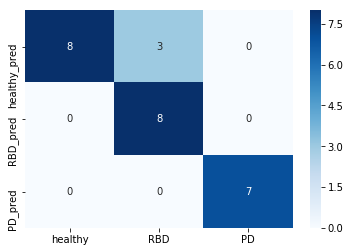

In [8]:
# make prediction
svc_pred = svc_clf.predict(test_X)
# make confusion matrix
svc_confusion = confusion_matrix(test_y, svc_pred)
svc_confusion = pd.DataFrame(svc_confusion.T, index=["healthy_pred", "RBD_pred", "PD_pred"], columns=["healthy", "RBD", "PD"])

# put confusion matrix in heatmap
sns.heatmap(svc_confusion, cmap="Blues", annot=True)

# print out confusion matrix report
report = classification_report(test_y, svc_pred, target_names=["healthy", "RBD", "PD"])
print(report)

## Conclusion
- Using motor and speech tests are sufficiently good differentiate the three groups. 

# Neural Network Classifier

## Split train_test data

In [9]:
# put selected features together
feature_dfs = [df_demograph, df["Years_of_symptoms"], df_UPDRS, df_speech]
df_nn = pd.concat(feature_dfs, axis=1)

# create labels: 0: healthy, 1: RBD, 2: PD
labels = np.asarray([2]*30 + [1]*50 + [0]*50)

# split train-test with 80/20 ratio
train_X, test_X, train_y, test_y = train_test_split(
    df_nn.values, 
    labels, 
    test_size=0.2,
    shuffle=True,
    random_state=79)

# scaler also scales "Age" and "Gender_male" columns
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

# convert labels to one-hot
train_y_OH = np.eye(3)[train_y]
test_y_OH = np.eye(3)[test_y]

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}")
print(f"test_y shape: {test_y.shape}")

train_X shape: (104, 54)
train_y shape: (104,)
test_X shape: (26, 54)
test_y shape: (26,)


## Define and train NN model

In [0]:
def nn_model(input_shape):

    X_inputs = Input(shape=input_shape)

    X = Dense(256, activation="relu")(X_inputs)
    X = BatchNormalization()(X)
    X = Dropout(0.7)(X)

    
    X = Dense(128, activation="relu")(X)
    X = BatchNormalization()(X)
    X = Dropout(0.7)(X)
    
    outputs = Dense(3, activation="softmax")(X)

    model = Model(inputs=X_inputs, outputs=outputs)

    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               14080     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

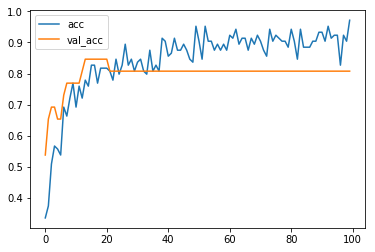

In [13]:
K.clear_session()

input_shape = train_X.shape[1]
nn_clf = nn_model(input_shape)
nn_clf.summary()

opt=Adam()
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, verbose=1, cooldown=10, min_delta=1e-4, min_lr=1e-5)

nn_clf.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
history = nn_clf.fit(
    train_X, 
    train_y_OH, 
    batch_size=16, 
    epochs=100, 
    validation_data=(test_X, test_y_OH),
    callbacks=[lr_reduction],
    verbose=0
)

plt.plot(history.history["acc"], label="acc")
plt.plot(history.history["val_acc"], label="val_acc")
plt.legend()

## Predictions and Confusion Matrix

              precision    recall  f1-score   support

     healthy       0.67      1.00      0.80         8
         RBD       0.88      0.64      0.74        11
          PD       1.00      0.86      0.92         7

    accuracy                           0.81        26
   macro avg       0.85      0.83      0.82        26
weighted avg       0.84      0.81      0.81        26



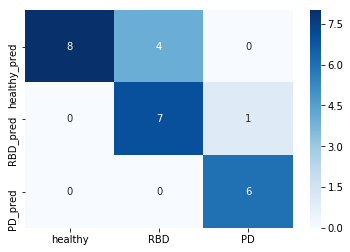

In [14]:
# make prediction
nn_pred_OH = nn_clf.predict(test_X)
nn_pred = np.argmax(nn_pred_OH, axis=-1)

# make confusion matrix
nn_confusion = confusion_matrix(test_y, nn_pred)
nn_confusion = pd.DataFrame(nn_confusion.T, index=["healthy_pred", "RBD_pred", "PD_pred"], columns=["healthy", "RBD", "PD"])

# put confusion matrix in heatmap
sns.heatmap(nn_confusion, cmap="Blues", annot=True)

# print out confusion matrix report
report = classification_report(test_y, nn_pred, target_names=["healthy", "RBD", "PD"])
print(report)


## Conclusion
- Neural network approach has comparable performance to SVC